In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import typing

class GA_Image_Transitioner:
    """
        Static methods
    """
    @staticmethod
    def load_image_data(image_path: str) -> np.array:
        return cv2.imread(image_path, cv2.IMREAD_UNCHANGED)[:, :, :3] 

    @staticmethod
    def load_image_alpha(image_path: str) -> np.array:
        return cv2.imread(image_path, cv2.IMREAD_UNCHANGED)[:, :, 3] 

    @staticmethod
    def store_image(image_path :str, image: np.array) -> None:
        cv2.imwrite(image_path, image)

    @staticmethod
    def from_shape_to_1D(image: np.array) -> np.array:
        return np.reshape(image, np.prod(list(image.shape)))
    
    @staticmethod
    def from_1D_to_shape(image: np.array, shape: typing.Tuple) -> np.array:
        return np.reshape(image, shape)
        
    """
        Constructor methods
    """
    def __init__(self, config):
        self.__init_config(config)
        self.__init_images()
        self.__init_individuals()
        self.__init_metrics()
        self.__init_first_generation()
    
    def __init_config(self, config: dict) -> None:
        self.config = config
        self.created_figure = False

    def __init_images(self) -> None:
        self.initial_image = GA_Image_Transitioner.load_image_data(self.config["images_path"][0]) 
        self.goal_image = GA_Image_Transitioner.load_image_data(self.config["images_path"][1]) 
        self.output_alpha = GA_Image_Transitioner.load_image_alpha(self.config["images_path"][1]) 

    def __init_individuals(self) -> None:
        self.initial_individual = GA_Image_Transitioner.from_shape_to_1D(self.initial_image)
        self.goal_individual = GA_Image_Transitioner.from_shape_to_1D(self.goal_image)

    def __init_metrics(self) -> None:
        self.initial_color_mismatch = np.abs(self.goal_individual - self.initial_individual).sum()
        self.maximum_color_mismatch = np.array(list(self.goal_individual.shape)).prod() * 255
        self.fitness_mean_history = []
        self.fitness_max_history = []

    def __init_first_generation(self) -> None:
        generation_size = self.config["number_of_parents"] + self.config["number_of_parents"]
        self.generation = np.array([self.initial_individual for _ in range(generation_size)])
        self.current_generation = self.config["first_generation_index"]
        self.fitness = self.__compute_fitness()
        self.__update_best_individual()
        self.chosen_mutation_policy = None

    """
        Public methods
    """
    def compute_and_store_next_image(self) -> typing.Generator:
        while abs(100 - self.accuracy_percentage) > self.config["error"]:
            self.__compute_new_generation()
            yield self.__store_current_generation_image()
    
    def describe_current_generation(self) -> None:
        print("accuracy_percentage = [{}], chosen_mutation_policy=[{}], generation=[{}]"\
            .format(self.accuracy_percentage, self.chosen_mutation_policy, self.current_generation))
    
    def plot_evolution(self) -> None:
        x_axis = np.linspace(0, self.current_generation - 1, self.current_generation)
        plt.plot(x_axis, self.fitness_mean_history, label = 'Mean Fitness')
        plt.plot(x_axis, self.fitness_max_history, label = 'Max Fitness')
        plt.legend()
        plt.title("Fitness through the {} generations".format(self.current_generation))
        plt.xlabel('Generations')
        plt.ylabel('Fitness')
        plt.show()


    """
        Private methods
    """
    def __update_best_individual(self) -> None:
        self.best_individual = self.__compute_best_individual()
        best_individual_color_mismatch = np.abs(self.goal_individual - self.best_individual).sum()
        self.accuracy_percentage = (1 - best_individual_color_mismatch / self.maximum_color_mismatch) * 100

    def __compute_best_individual(self) -> np.array:
        if self.fitness is None:
            self.fitness = self.__compute_fitness()

        return self.generation[np.argmax(self.fitness)]

    def __compute_fitness(self) -> np.array:
        return np.array([self.__individual_fitness(individual) for individual in self.generation])

    def __individual_fitness(self, individual : np.array) -> np.array:
        color_mismatch = abs(individual - self.goal_individual).sum()
        # maximum fitness is 0
        return -1 * color_mismatch

    def __get_current_generation_path(self) -> str:
        return "generations/generation{}.png".format(self.current_generation)

    def __compute_new_generation(self) -> None:
        if self.current_generation > self.config["max_generations"]:
            raise Exception("The max_generations limit({}) has been reached!".format(self.config["max_generations"]))

        parents = self.__selection()
        offsprings = self.__crossover(parents)
        mutants = self.__mutation(offsprings)
        
        self.generation = np.concatenate([offsprings, mutants])
        self.fitness = self.__compute_fitness()
        self.__update_best_individual()
        self.__update_metrics()


    def __selection(self) -> np.array:
        return self.__roullete_wheel_selection()
    
    def __roullete_wheel_selection(self) -> np.array:
        fitness_sum = self.fitness.sum()
        if fitness_sum == 0:
            return np.array([random.choice(self.generation)])

        generation_enhanced = list(zip(self.generation, self.fitness)) 
        selection_probabilities = [pair[1] / fitness_sum for pair in generation_enhanced]
        number_of_individuals, _ = self.generation.shape
        return np.array(\
            [self.generation[np.random.choice(number_of_individuals, p = selection_probabilities)] \
                for _ in range(self.config["number_of_parents"])] \
        )

    def __crossover(self, parents: np.array) -> np.array:
        number_of_offsprings = self.config["number_of_offsprings"]
        number_of_parents, number_of_chromosomes = parents.shape
        offsprings = np.zeros((number_of_offsprings, number_of_chromosomes))
        
        crossover_point = int(number_of_parents / 2)
        
        for offspring_index in range(number_of_offsprings):
            first_parent = random.choice(parents)
            second_parent = random.choice(parents)
            offsprings[offspring_index][0:crossover_point] = first_parent[0:crossover_point]
            offsprings[offspring_index][crossover_point:] = second_parent[crossover_point:]
        
        return offsprings

    def __mutation(self, offsprings: np.array) -> np.array:
        number_of_individuals, number_of_chromosomes = offsprings.shape 
        self.__compute_mutation_policy()
        
        for offspring_index in range(number_of_individuals):
            individual = offsprings[offspring_index]
            
            final_mutation_signal = self.__compute_final_mutation_signal(individual, number_of_chromosomes)
            individual += final_mutation_signal

            offsprings[offspring_index] = np.vectorize(lambda x: 0 if x < 0 else (255 if x > 255 else x))(individual)
        
        return offsprings 
    
    def __compute_final_mutation_signal(self, individual: np.array, number_of_chromosomes: int) -> np.array:
        color_mismatch_direction = self.__get_color_mismatch_directions_to_goal(individual)
        mutation_signal = self.__compute_random_mutation_signal(number_of_chromosomes)
        
        if self.chosen_mutation_policy == "guided_mutation":
            return color_mismatch_direction 
                
        if self.chosen_mutation_policy == "guided_random_signal_mutation":
            return color_mismatch_direction * np.abs(mutation_signal)
        elif self.chosen_mutation_policy == "unguided_random_signal_mutation":
            return mutation_signal

        raise Exception("Mutation policy [{}] does not exist!".format(self.chosen_mutation_policy))

    def __compute_mutation_policy(self) -> None:
        if self.accuracy_percentage > self.config["treshold_for_guided_mutation"]:
            self.chosen_mutation_policy = "guided_mutation"
        else:
            self.chosen_mutation_policy = "guided_random_signal_mutation"

    def __get_color_mismatch_directions_to_goal(self, individual: np.array) -> np.array:
        color_mismatch = self.goal_individual - individual
        return np.vectorize(lambda x: int(x + 1) if x > 0 else (0 if x == 0 else int(x - 1)))(color_mismatch / 255)

    def __compute_random_mutation_signal(self, number_of_chromosomes: int) -> np.array:
        mutation_config = self.config["mutation"]
        number_of_samples = number_of_chromosomes
        sampling_frequency = number_of_samples
        time_array = np.arange(number_of_samples)

        signal = np.zeros(number_of_samples)
        for _ in range(mutation_config["number_of_sine_functions"]):
            random_starting_phase = random.random() * np.pi
            signal_frequency = int(random.random() * mutation_config["frequency_range"] + mutation_config["min_frequency"])
            random_signal = np.sin(random_starting_phase + signal_frequency / sampling_frequency * time_array)
            signal += random_signal
        
        random_amplitude = random.random() * mutation_config["amplitude_range"] + mutation_config["min_amplitude"]
        return random_amplitude * signal

    def __update_metrics(self) -> None:
        self.fitness_max_history.append(np.max(self.fitness))
        self.fitness_mean_history.append(np.mean(self.fitness))
        self.current_generation += 1

    def __store_current_generation_image(self) -> None:
        best_individual_image = GA_Image_Transitioner.from_1D_to_shape(self.best_individual, self.goal_image.shape) 
        GA_Image_Transitioner.store_image(self.__get_current_generation_path(), self.__wrap_with_alpha(best_individual_image))

    def __wrap_with_alpha(self, transition_image: np.array) -> np.array:
        return np.dstack([transition_image, self.output_alpha])

In [2]:
config = {
    "images_path": ("input/forktex.png", "input/me.png"),
    "number_of_parents": 1,
    "number_of_offsprings": 1,
    "max_generations": 1000,
    "first_generation_index": 0,
    "treshold_for_guided_mutation": 90,
    "error": 10e-2,
    "mutation": {
        "number_of_sine_functions": 4,
        "min_frequency": 0,
        "frequency_range": 10e5,
        "min_amplitude": 0,
        "amplitude_range": 4
    }
}

transitioner = GA_Image_Transitioner(config)

In [4]:
for _ in transitioner.compute_and_store_next_image():
    transitioner.describe_current_generation()

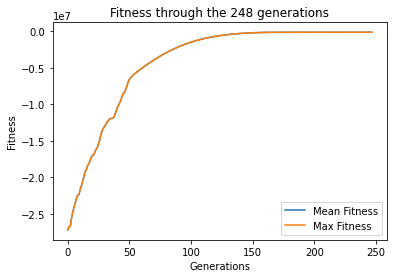

In [5]:
transitioner.plot_evolution()

# Mutation Signal demo

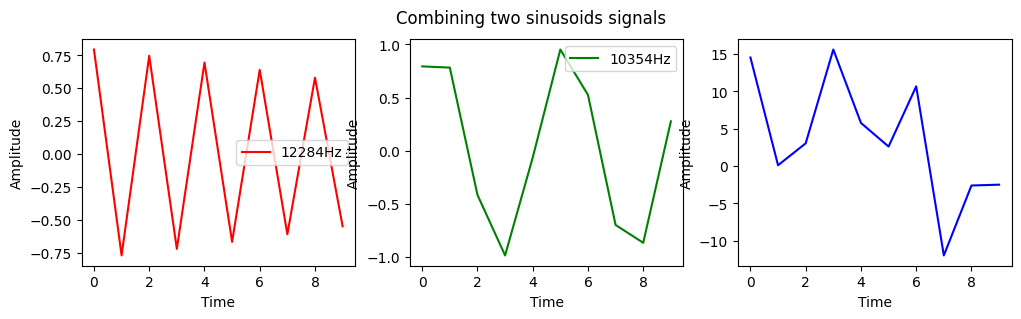

In [6]:
NUMBER_OF_SAMPLES = 10
SAMPLING_FREQUENCY = NUMBER_OF_SAMPLES

MIN_FREQUENCY = 5000
FREQUENCY_BAND = 10000
MIN_AMPLITUDE = 0
AMPLITUDE_RANGE = 20

random_starting_phase = random.random() * np.pi 
TIME_ARRAY = np.arange(NUMBER_OF_SAMPLES)
FIRST_FREQUENCY = int(random.random() * FREQUENCY_BAND + MIN_FREQUENCY)
SECOND_FREQUENCY = int(random.random() * FREQUENCY_BAND + MIN_FREQUENCY)

first_sine = np.sin(random_starting_phase + FIRST_FREQUENCY/SAMPLING_FREQUENCY * TIME_ARRAY) 
second_sine = np.sin(random_starting_phase + SECOND_FREQUENCY/SAMPLING_FREQUENCY * TIME_ARRAY)
combined_sine = first_sine + second_sine



RANDOM_AMPLITUDE = random.random() * AMPLITUDE_RANGE + MIN_AMPLITUDE
combined_sine =  RANDOM_AMPLITUDE *  combined_sine
combined_sine =  np.abs(combined_sine)
direction = np.array([1, 1, 1, 1, 1, 1, 1, -1, -1, -1])
combined_sine = direction * combined_sine

fig=plt.figure(figsize=(12,3), dpi= 100, facecolor='w', edgecolor='k')
fig.suptitle('Combining two sinusoids signals');

plt.subplot(1,3,1);
plt.plot(TIME_ARRAY, first_sine, color = 'r', label=str(FIRST_FREQUENCY) + 'Hz'); 
plt.xlabel('Time');
plt.ylabel('Amplitude');
plt.legend()

plt.subplot(1,3,2);
plt.plot(TIME_ARRAY, second_sine, color = 'g', label=str(SECOND_FREQUENCY) + 'Hz');
plt.xlabel('Time');
plt.ylabel('Amplitude');
plt.legend()

plt.subplot(1,3,3);
plt.plot(TIME_ARRAY, combined_sine, color = 'b');
plt.xlabel('Time');
plt.ylabel('Amplitude');